**Q.2 Understanding model order and overfitting**

In [2]:
#All imports

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider

In [3]:
#Generate 20 data points

x = np.random.uniform(0,1,20)
y_true = np.sin(2*np.pi*x)
y = y_true + np.random.normal(0,0.1,20) #Adding noise to data
df = pd.DataFrame({'x':x, 'y':y})
print(df)

           x         y
0   0.474437  0.118492
1   0.059653  0.408963
2   0.921894 -0.505597
3   0.803721 -0.976567
4   0.497692  0.062089
5   0.475935  0.035985
6   0.761816 -1.063170
7   0.779204 -0.680046
8   0.253901  0.827645
9   0.882412 -0.833006
10  0.201565  1.001412
11  0.443985  0.342176
12  0.327082  0.752617
13  0.543840 -0.203802
14  0.775871 -0.817996
15  0.602594 -0.759846
16  0.176821  0.925489
17  0.234837  0.992811
18  0.936703 -0.317792
19  0.794481 -0.909728


In [4]:
# Obtain train and test splits

train_df = df.iloc[::2].reset_index(drop=True)
test_df = df.iloc[1::2].reset_index(drop=True)
print(train_df)
print(test_df)

X_train = train_df['x']
Y_train = train_df['y']
X_test = test_df['x']
Y_test = test_df['y']

          x         y
0  0.474437  0.118492
1  0.921894 -0.505597
2  0.497692  0.062089
3  0.761816 -1.063170
4  0.253901  0.827645
5  0.201565  1.001412
6  0.327082  0.752617
7  0.775871 -0.817996
8  0.176821  0.925489
9  0.936703 -0.317792
          x         y
0  0.059653  0.408963
1  0.803721 -0.976567
2  0.475935  0.035985
3  0.779204 -0.680046
4  0.882412 -0.833006
5  0.443985  0.342176
6  0.543840 -0.203802
7  0.602594 -0.759846
8  0.234837  0.992811
9  0.794481 -0.909728


In [5]:
# Function to fit an Mth degree polynomial to training data
def PolynomialFit(X_train,Y_train,M,lamda,regularize_bias = True):
    #Transform the data using polynomial kernel
    X_polynomial_train = np.array([[xi**i for i in range(M+1)] for xi in X_train])

    XT = X_polynomial_train.T
    I = np.eye(X_polynomial_train.shape[1])

    if not regularize_bias:
        I[0, 0] = 0

    #Find Pseudo inverse solution
    if lamda == 0:
        w_opt = np.linalg.pinv(XT @ X_polynomial_train) @ XT @ Y_train
    else:
        w_opt = np.linalg.inv(XT @ X_polynomial_train + lamda*I) @ XT @ Y_train

    #return the weight vector
    return w_opt

# Function to return the predicted values
def PolynomialPred(w_est,X_train,X_test):
    M = len(w_est) - 1

    X_polynomial_train = np.array([[xi**i for i in range(M+1)] for xi in X_train])
    X_polynomial_test = np.array([[xi**i for i in range(M+1)] for xi in X_test])

    y_train_pred = X_polynomial_train @ w_est
    y_test_pred = X_polynomial_test @ w_est

    return y_train_pred , y_test_pred

# Function to return the RMSE
def PolynomialPred_Error(w_est,X_train,X_test,Y_train,Y_test):
    M = len(w_est) - 1

    X_polynomial_train = np.array([[xi**i for i in range(M+1)] for xi in X_train])
    X_polynomial_test = np.array([[xi**i for i in range(M+1)] for xi in X_test])

    y_train_pred = X_polynomial_train @ w_est
    y_test_pred = X_polynomial_test @ w_est

    #RMSE Error
    rmse_train = np.sqrt(np.mean((y_train_pred - Y_train)**2))
    rmse_test = np.sqrt(np.mean((y_test_pred - Y_test)**2))

    return rmse_train, rmse_test

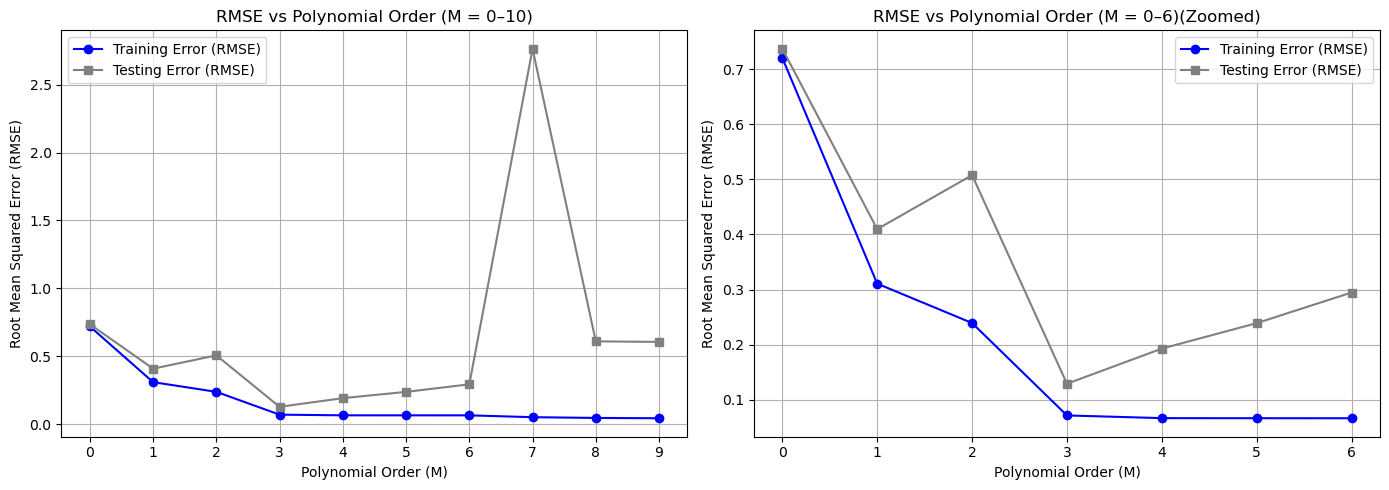

In [6]:
#  Iterate through range of M values and plot training and test error vs polynomial order
M_range=list(range(10))
TrError = []
TeError = []
TrPred = []
TePred = []

for M in M_range:
  # Fit Mth order polynomial
  w_opt = PolynomialFit(X_train, Y_train, M, lamda=0)

  #Predict tragets
  y_train_pred, y_test_pred = PolynomialPred(w_opt, X_train, X_test)

  # Predict errors
  rmse_train, rmse_test = PolynomialPred_Error(w_opt, X_train, X_test, Y_train, Y_test)

  # Store errors
  TrError.append(rmse_train)
  TeError.append(rmse_test)

  # Store predictions
  TrPred.append(y_train_pred)
  TePred.append(y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot M(0–10) on the first subplot of polynomial order vs RMSE
axes[0].plot(M_range, TrError, marker='o', label='Training Error (RMSE)', color='blue')
axes[0].plot(M_range, TeError, marker='s', label='Testing Error (RMSE)', color='grey')
axes[0].set_title('RMSE vs Polynomial Order (M = 0–10)')
axes[0].set_xlabel('Polynomial Order (M)')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(M_range)

# Plot M(0–6) on the second subplot (Zoomed version of the first plot to see the errors more closely)
M_range_zoom = list(range(7))
TrError_zoom = TrError[:7]
TeError_zoom = TeError[:7]

axes[1].plot(M_range_zoom, TrError_zoom, marker='o', label='Training Error (RMSE)', color='blue')
axes[1].plot(M_range_zoom, TeError_zoom, marker='s', label='Testing Error (RMSE)', color='grey')
axes[1].set_title('RMSE vs Polynomial Order (M = 0–6)(Zoomed)')
axes[1].set_xlabel('Polynomial Order (M)')
axes[1].set_ylabel('Root Mean Squared Error (RMSE)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(M_range_zoom)

plt.tight_layout()
plt.show()

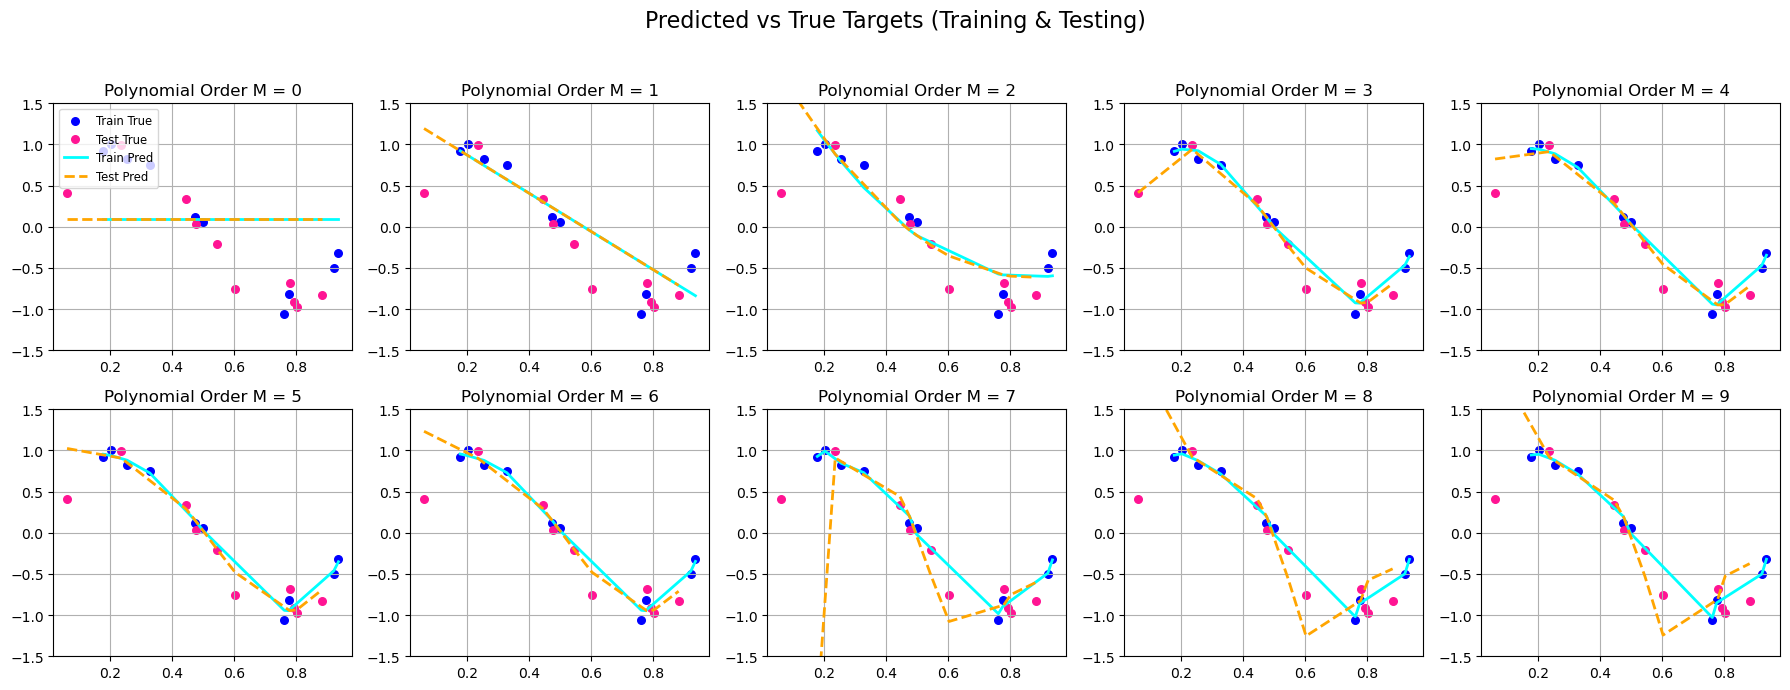

In [7]:
#Plot training and testing estimates alogwith the original targets
num_cols = 5
num_rows = 2

plt.figure(figsize=(18, 7))
for i, M in enumerate(M_range):
    plt.subplot(num_rows, num_cols, i + 1)

    # Sort training data for smooth lines
    train_sort = np.argsort(X_train)
    test_sort = np.argsort(X_test)

    # Scatter actual values
    plt.scatter(X_train, Y_train, color='blue', label='Train True', s=30)
    plt.scatter(X_test, Y_test, color='deeppink', label='Test True', s=30)

    # Line plot for predicted values (sorted for smoothness)
    plt.plot(X_train[train_sort], TrPred[i][train_sort], color='cyan', label='Train Pred', linewidth=2)
    plt.plot(X_test[test_sort], TePred[i][test_sort], color='orange', label='Test Pred', linewidth=2, linestyle='--')

    plt.title(f'Polynomial Order M = {M}')
    plt.ylim(-1.5, 1.5)
    plt.grid(True)

    if i == 0:
        plt.legend(loc='upper left', fontsize='small')

plt.suptitle('Predicted vs True Targets (Training & Testing)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

From the graphs, we can see that models with higher polynomial orders (M = 6 to 9) achieve very low training errors but suffer from a sharp increase in testing error. This indicates overfitting, where the model fits the training data too closely—including noise—and fails to generalize well to unseen data.

On the other hand, lower-order models (e.g., M = 0 or 1) have relatively high errors on both training and testing sets, indicating underfitting, where the model is too simple to capture the underlying patterns in the data.

Models with intermediate orders, particularly M = 3-5/6, strike a balance—achieving low error on both training and testing data. These represent a good fit and demonstrate optimal model complexity.

In [9]:
#Increase the size of training data set to 100 points and repeat the experiments

x_1 = np.random.uniform(0,1,100)
y_1_true = np.sin(2*np.pi*x_1)
y_1 = y_1_true + np.random.normal(0,0.1,100) #Adding noise
df1 = pd.DataFrame({'x':x_1, 'y':y_1})
print(df1)

           x         y
0   0.419540  0.666432
1   0.019642 -0.071540
2   0.047399  0.367071
3   0.250239  0.945016
4   0.330221  0.920346
..       ...       ...
95  0.319934  0.811465
96  0.054959  0.319246
97  0.241333  0.951796
98  0.497987 -0.014491
99  0.590273 -0.570680

[100 rows x 2 columns]


In [10]:
#Obtain train and test splits

train_df_1 = df1.iloc[::2].reset_index(drop=True)
test_df_1 = df1.iloc[1::2].reset_index(drop=True)
print(train_df_1)
print(test_df_1)

           x         y
0   0.419540  0.666432
1   0.047399  0.367071
2   0.330221  0.920346
3   0.428393  0.462184
4   0.581967 -0.587286
5   0.199308  0.982873
6   0.717235 -1.088040
7   0.565588 -0.336742
8   0.683690 -1.012590
9   0.750839 -0.995444
10  0.287860  1.090792
11  0.116359  0.702793
12  0.987351 -0.159705
13  0.869613 -0.598302
14  0.797857 -1.046466
15  0.876597 -0.723003
16  0.110800  0.809356
17  0.698725 -0.966214
18  0.583397 -0.418471
19  0.026925 -0.026446
20  0.075514  0.506711
21  0.402231  0.587401
22  0.294574  0.871690
23  0.065056  0.374487
24  0.715791 -1.062278
25  0.352871  0.725333
26  0.658018 -0.708120
27  0.047773  0.342321
28  0.421708  0.482107
29  0.567342 -0.335518
30  0.966383 -0.353286
31  0.308693  0.979393
32  0.692795 -1.052519
33  0.835284 -0.889588
34  0.572592 -0.361378
35  0.176230  0.976134
36  0.223501  1.121791
37  0.502777 -0.075379
38  0.433884  0.368577
39  0.766576 -1.008406
40  0.480713 -0.009546
41  0.572510 -0.341416
42  0.37844

In [11]:
X_train1 = train_df_1['x']
Y_train1 = train_df_1['y']
X_test1 = test_df_1['x']
Y_test1 = test_df_1['y']

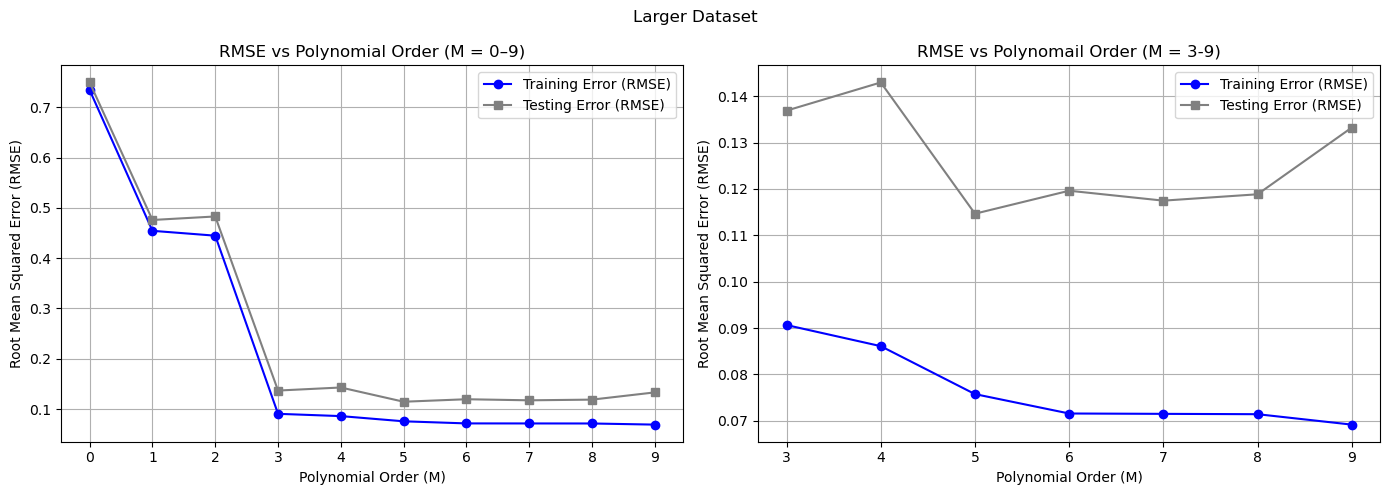

In [12]:
#Iterate through range of M values for larger dataset
M_range=list(range(10))
TrError1 = []
TeError1 = []
TrPred1 = []
TePred1 = []

for M in M_range:
  # Fit Mth order polynomial
  w_opt_1 = PolynomialFit(X_train1, Y_train1, M, lamda=0)

  #Predict tragets
  y_train_pred_1, y_test_pred_1 = PolynomialPred(w_opt_1, X_train1, X_test1)

  # Predict errors
  rmse_train_1, rmse_test_1 = PolynomialPred_Error(w_opt_1, X_train1, X_test1, Y_train1, Y_test1)

  # Store errors
  TrError1.append(rmse_train_1)
  TeError1.append(rmse_test_1)

  # Store predictions
  TrPred1.append(y_train_pred_1)
  TePred1.append(y_test_pred_1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 0–9 on the first subplot
axes[0].plot(M_range, TrError1, marker='o', label='Training Error (RMSE)', color='blue')
axes[0].plot(M_range, TeError1, marker='s', label='Testing Error (RMSE)', color='grey')
axes[0].set_title('RMSE vs Polynomial Order (M = 0–9)')
axes[0].set_xlabel('Polynomial Order (M)')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xticks(M_range)

# Plot 3-9 on the second subplot
M_range_zoom = list(range(3,10))
TrError_zoom1 = TrError1[3:10]
TeError_zoom1 = TeError1[3:10]

axes[1].plot(M_range_zoom, TrError_zoom1, marker='o', label='Training Error (RMSE)', color='blue')
axes[1].plot(M_range_zoom, TeError_zoom1, marker='s', label='Testing Error (RMSE)', color='grey')
axes[1].set_title('RMSE vs Polynomail Order (M = 3-9)')
axes[1].set_xlabel('Polynomial Order (M)')
axes[1].set_ylabel('Root Mean Squared Error (RMSE)')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xticks(M_range_zoom)

plt.suptitle('Larger Dataset')
plt.tight_layout()
plt.show()

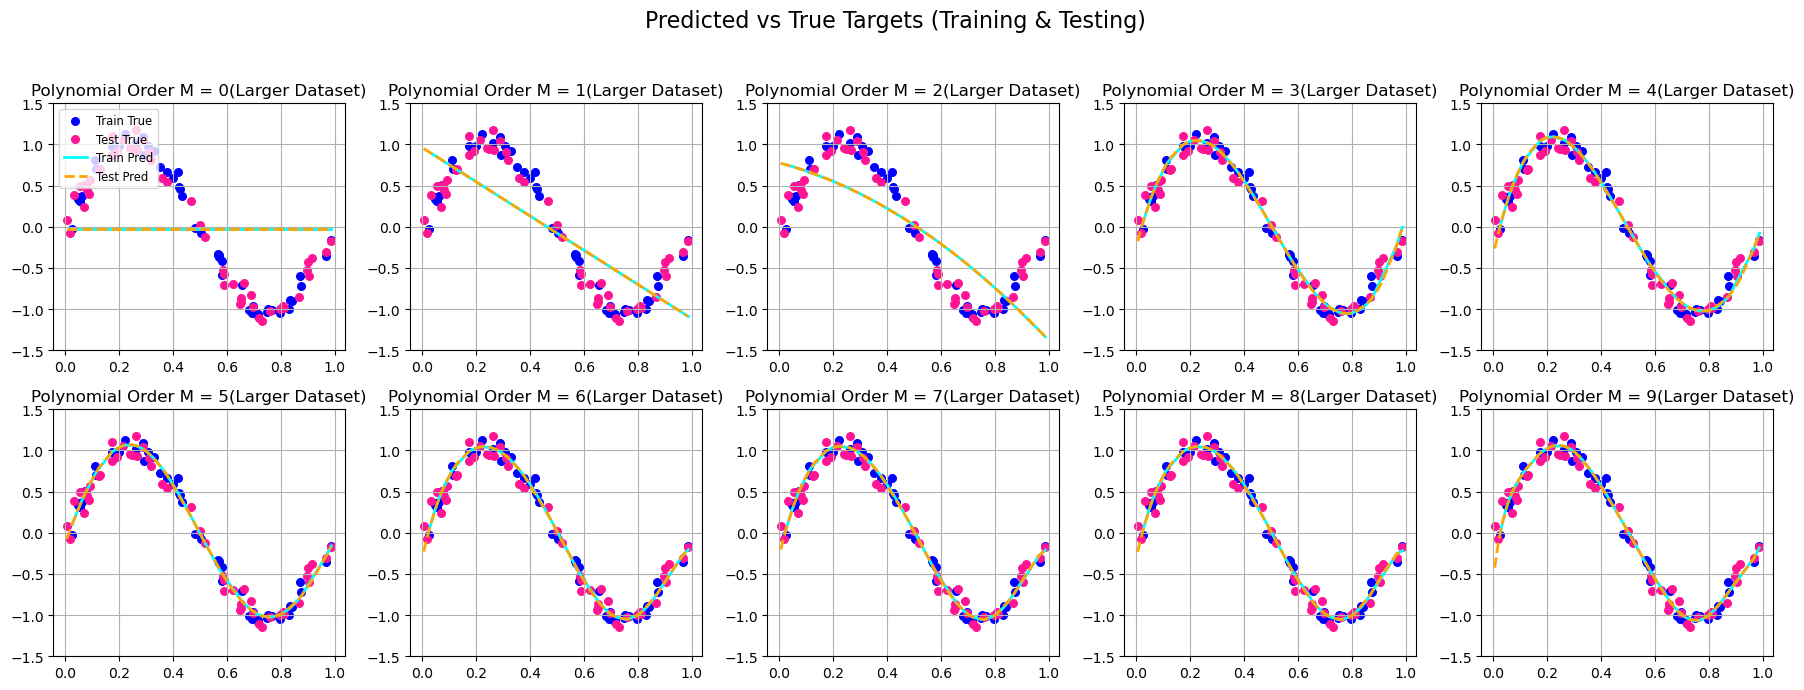

In [13]:
# Plot training and testing estimates along with the original tragets

num_rows = 2
num_cols = 5

plt.figure(figsize=(18, 7))
for i, M in enumerate(M_range):
    plt.subplot(num_rows, num_cols, i + 1)

    # Sort training data for smooth lines
    train_sort_1 = np.argsort(X_train1)
    test_sort_1 = np.argsort(X_test1)

    # Scatter actual values
    plt.scatter(X_train1, Y_train1, color='blue', label='Train True', s=30)
    plt.scatter(X_test1, Y_test1, color='deeppink', label='Test True', s=30)

    # Line plot for predicted values (sorted for smoothness)
    plt.plot(X_train1[train_sort_1], TrPred1[i][train_sort_1], color='cyan', label='Train Pred', linewidth=2)
    plt.plot(X_test1[test_sort_1], TePred1[i][test_sort_1], color='orange', label='Test Pred', linewidth=2, linestyle='--')

    plt.title(f'Polynomial Order M = {M}(Larger Dataset)')
    plt.ylim(-1.5, 1.5)
    plt.grid(True)

    if i == 0:
        plt.legend(loc='upper left', fontsize='small')

plt.suptitle('Predicted vs True Targets (Training & Testing)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Reduced Overfitting with More Data**

More training data helps the model generalize better. Higher-order polynomials that once overfit the small dataset now capture true patterns, reducing test error. While training error may slightly increase (as the model can't memorize all points), it's a good trade-off for better generalization. Low-order models may still underfit, but overfitting in complex models reduces — shifting the optimal model order slightly higher (around 5-7).

In [15]:
#Effect of regularisation

def analyze_regularization(X_train, X_test, y_train, y_test, dataset_name,regularise_bias_ = True):
    M_range = range(10)
    lambdas = [0,1e-7, 1e-4, 0.01, 1]
    num_lambdas = len(lambdas)

    num_cols = 5
    num_rows = 2

    plt.figure(figsize=(20, 10))

    for i, lamda in enumerate(lambdas):
        TrError_reg, TeError_reg = [], []

        for M in M_range:
            if not regularise_bias_:
              w_opt_reg = PolynomialFit(X_train, y_train, M, lamda, False)
            else:
              w_opt_reg = PolynomialFit(X_train, y_train, M, lamda)
            rmse_train_reg, rmse_test_reg = PolynomialPred_Error(w_opt_reg, X_train, X_test, y_train, y_test)
            TrError_reg.append(rmse_train_reg)
            TeError_reg.append(rmse_test_reg)

        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(M_range, TrError_reg, marker='o', linestyle='-', color='blue', label='Train RMSE')
        plt.plot(M_range, TeError_reg, marker='s', linestyle='--', color='grey', label='Test RMSE')

        plt.xlabel('Polynomial Degree (M)')
        plt.ylabel('RMSE')
        plt.title(f'λ = {lamda}')
        plt.grid(True)
        plt.xticks(M_range)
        if i == 0:
            plt.legend()

    plt.suptitle(f'Regularization Impact on Train/Test RMSE ({dataset_name} Dataset)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

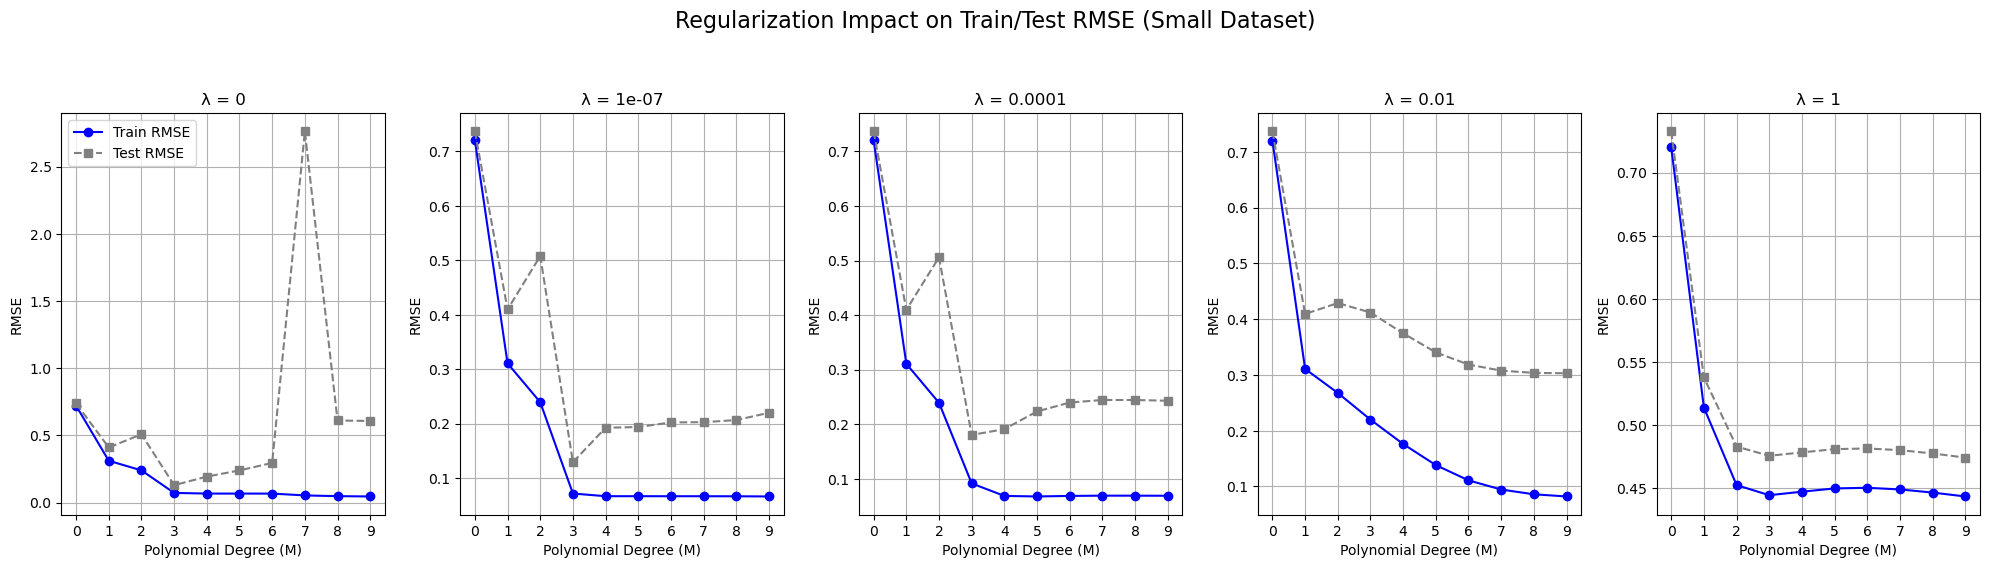

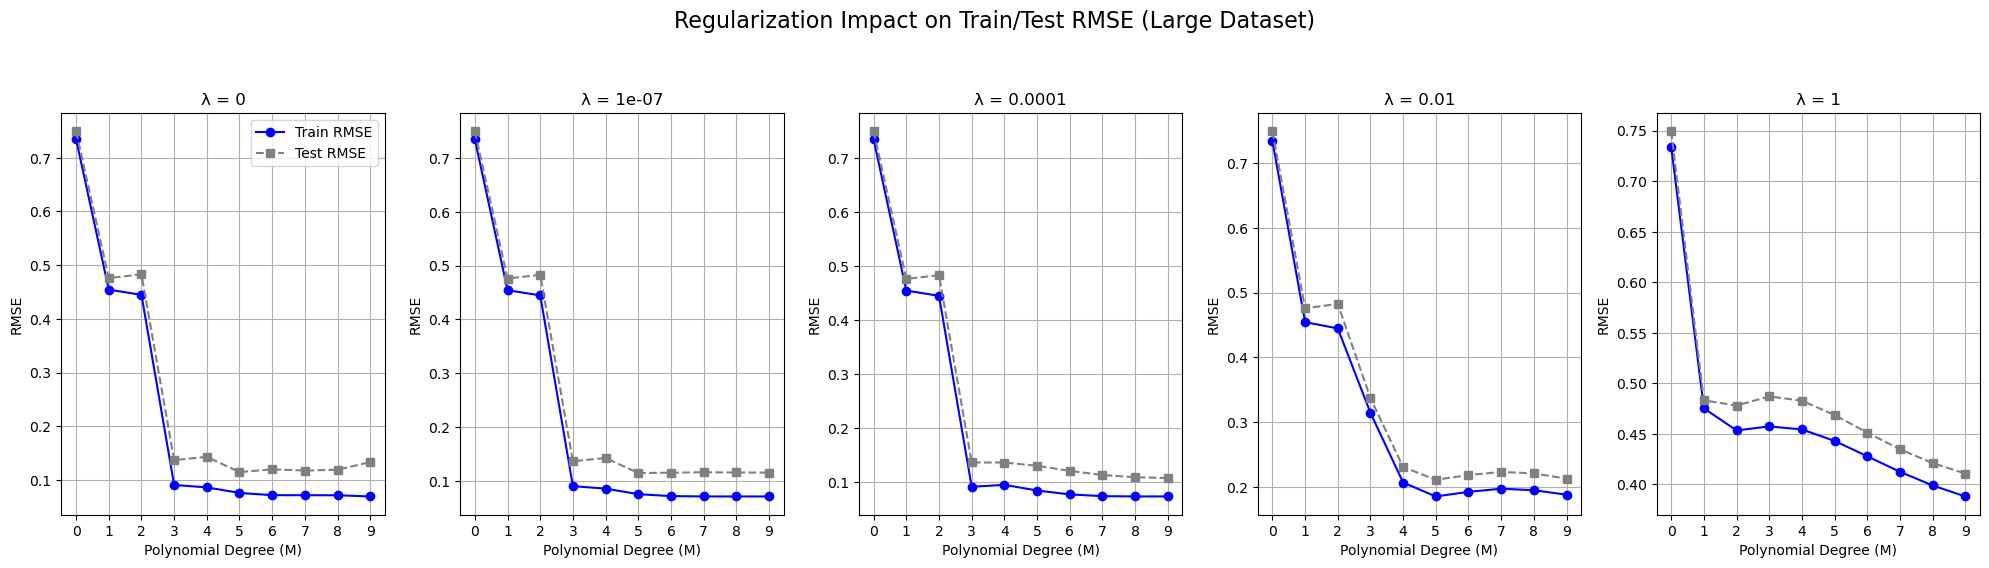

In [16]:
analyze_regularization(X_train, X_test, Y_train, Y_test, 'Small')
analyze_regularization(X_train1, X_test1, Y_train1, Y_test1, 'Large')

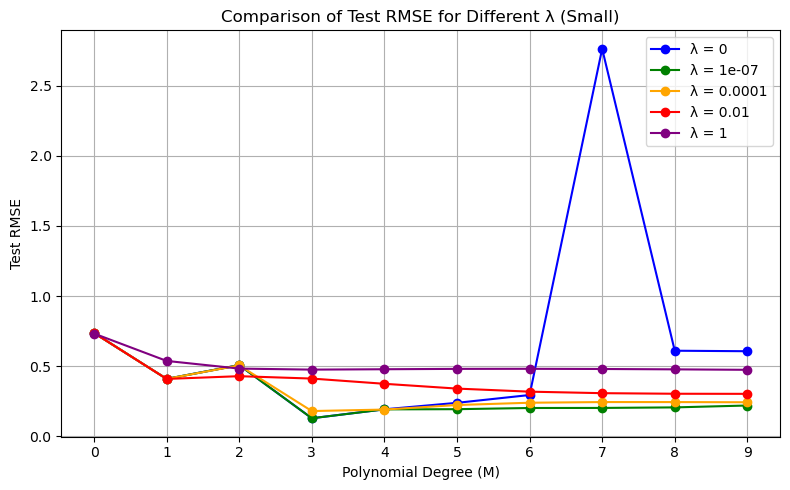

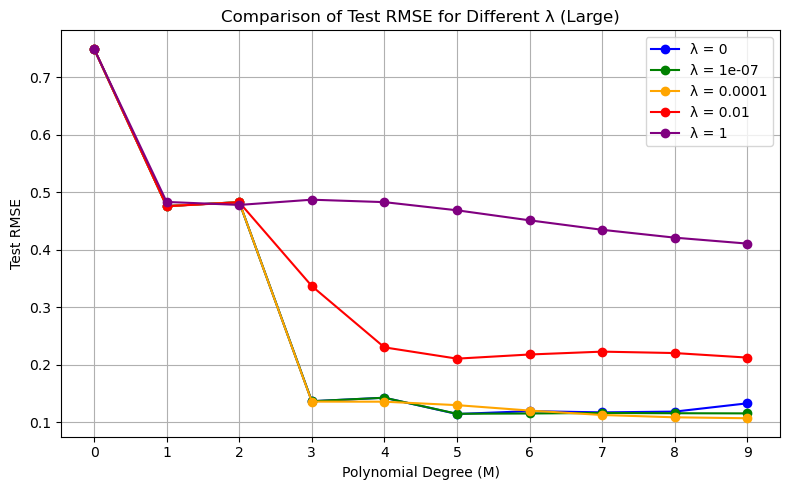

In [17]:
def compare_regularization_effects(X_train, X_test, y_train, y_test, dataset_name, regularise_bias_ = True):
    M_range = range(10)
    lambdas = [0, 1e-7, 1e-4, 0.01, 1]
    colors = ['blue', 'green', 'orange', 'red', 'purple']

    plt.figure(figsize=(8, 5))

    for i, lamda in enumerate(lambdas):
        TeError_reg = []

        for M in M_range:
            if not regularise_bias_:
                w_opt_reg = PolynomialFit(X_train, y_train, M, lamda, False)
            else:
                w_opt_reg = PolynomialFit(X_train, y_train, M, lamda)
            _, rmse_test_reg = PolynomialPred_Error(w_opt_reg, X_train, X_test, y_train, y_test)
            TeError_reg.append(rmse_test_reg)

        plt.plot(M_range, TeError_reg, marker='o', linestyle='-', color=colors[i], label=f'λ = {lamda}')

    plt.xlabel('Polynomial Degree (M)')
    plt.ylabel('Test RMSE')
    plt.title(f'Comparison of Test RMSE for Different λ ({dataset_name})')
    plt.grid(True)
    plt.xticks(M_range)
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_regularization_effects(X_train, X_test, Y_train, Y_test, 'Small')
compare_regularization_effects(X_train1, X_test1, Y_train1, Y_test1, 'Large')

For the dataset with 10 points:
*   Without regularization (λ = 0), training error decreases with model
complexity, but test error spikes for higher degrees — showing clear overfitting.
*   With small regularization, overfitting is reduced; training error stays low, and test error remains stable.
*   Moderate regularization gives the best bias-variance trade-off, enabling higher-degree models to generalize well.
*   Strong regularization leads to underfitting, with both errors remaining high due to excessive constraint on the model.

For the dataset with 100 points:

Regularization has a smaller impact due to sufficient training data. The best performance is achieved with minimal regularization, as overfitting is naturally reduced. Here also, strong regularization leads to underfitting, with both errors remaining high due to excessive constraint on the model.

In [20]:
# effect of bias regularisation
#Adding 5 to the original datasets will do it becasue the function 5 + sin(2*pi*x)

# Generating data
y_bias_train_small = 5 + Y_train
y_bias_train_large = 5 + Y_train1
y_bias_test_small = 5 + Y_test
y_bias_test_large = 5 + Y_test1

In [21]:
#Smaller dataset

w_opt_without_bias_reg = PolynomialFit(X_train, y_bias_train_small,M=3,lamda=10, regularize_bias=True)
w_opt_with_bias_reg = PolynomialFit(X_train,y_bias_train_small,3, 10, False)
print(w_opt_without_bias_reg)
print(w_opt_with_bias_reg)

[2.19643448 0.85571937 0.45342658 0.30301774]
[ 5.26859732 -0.14656074 -0.15196846 -0.13201971]


In [22]:
#Larger dataset

w_opt_without_bias = PolynomialFit(X_train1, y_bias_train_large,5, 10, True)
w_opt_with_bias = PolynomialFit(X_train1,y_bias_train_large,5, 10, False)
print(w_opt_without_bias)
print(w_opt_with_bias)

[ 3.83801153  0.75110344  0.12370603 -0.04026217 -0.07644299 -0.07332726]
[ 5.3590983  -0.3732351  -0.35310054 -0.26391957 -0.17926697 -0.11218846]


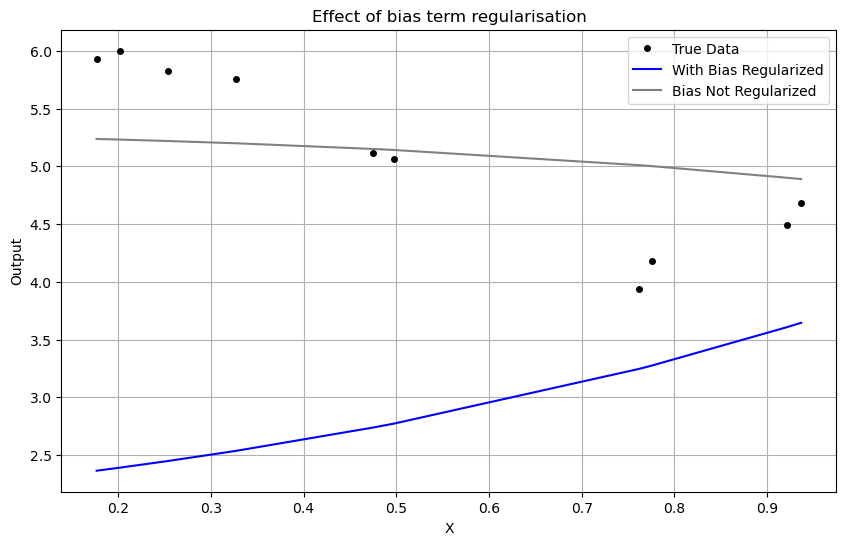

In [23]:
y_pred_no_bias_train, _ = PolynomialPred(w_opt_without_bias_reg, X_train, X_test)
y_pred_with_bias_train, _ = PolynomialPred(w_opt_with_bias_reg, X_train, X_test)

sort_idx = np.argsort(X_train)

plt.figure(figsize=(10, 6))
plt.plot(X_train, y_bias_train_small, 'ko', label='True Data', markersize=4)
plt.plot(X_train[sort_idx], y_pred_no_bias_train[sort_idx], 'blue', label='With Bias Regularized')
plt.plot(X_train[sort_idx], y_pred_with_bias_train[sort_idx], 'grey', label='Bias Not Regularized')
plt.title('Effect of bias term regularisation')
plt.xlabel('X')
plt.ylabel('Output')
plt.grid(True)
plt.legend()
plt.show()

At moderate or high regularisation, bias term differences become significant and Non-bias terms shrink noticeably in both models.

Without bias regularisation, the bias coefficient w0 tends to 5(true function mean). and that with bias regularisation shrunks to 0.  

Bias regularization significantly impacts model behavior. It shrinks intercept towards 0 for non centered data. It should generally be avoided unless all features/targets are standardized.



**OBSERVATIONS**

1. Low-order polynomial models tend to underfit the data, failing to capture underlying patterns, while high-order models often overfit especially with limited data by fitting noise and losing generalization. The best performance is typically observed at intermediate model orders (around M = 3 to 5 or 6), where the model balances complexity and generalization.

2. Overfitting can be reduced either by increasing training data or regularisation.For smaller datasets, regularization plays a crucial role in controlling overfitting; moderate regularization leads to better test performance. In contrast, larger datasets naturally reduce overfitting, so minimal or no regularization works best, and strong regularization causes underfitting.

3. Regularizing the bias term shrinks the intercept toward zero, which can distort predictions when the data is not centered. Therefore, bias regularization should generally be avoided unless both inputs and targets are standardized.